### Preparation: import libraries, define IAM role

In [1]:
bucket = 'sagemaker-frank-hw2'
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

### Data preparation 

In [3]:
# download s3 data to local for processing
import botocore

BUCKET_NAME = 'sagemaker-frank-hw2' # replace with your bucket name
KEY1 = 'FILE_1.csv' # replace with your object key
KEY2 = 'FILE_2.csv'

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY1, 'FILE_1.csv')
    s3.Bucket(BUCKET_NAME).download_file(KEY2, 'FILE_2.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [4]:
# load training data
training = pd.read_csv('./FILE_2.csv')
pd.set_option('display.max_columns', 5)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
training.head()

,Business_ID,Cuisine,Rating,Num_of_Reviews,Recommended
0,MNNpsRXe7Wt5m3Jla9Wk0w,mexican,5.0,671.0,1
1,VVe74-TKuROBvyS1XgVmvw,mexican,5.0,330.0,1
2,UtknyDJ_DPut-FKRqs0wpQ,indian,5.0,245.0,1
3,AFt1Qcec4_JNr6PWpkRYyw,sushi,5.0,204.0,1
4,3rZwXDjkyDLAHNSdPUI5WA,indian,5.0,166.0,1


In [5]:
# list the headers of dataframe
list(training)

['Business_ID', 'Cuisine', 'Rating', 'Num_of_Reviews', 'Recommended']

In [7]:
# load testing data 
test = pd.read_csv('./FILE_1.csv')
test.head()

,Business_ID,Cuisine,Rating,Num_of_Reviews
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,2.5,439.0
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,4.5,650.0
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,4.0,274.0
3,0CjK3esfpFcxIopebzjFxA,chinese,4.0,5672.0
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,4.5,1152.0


In [9]:
# data transformation: drop id
training = training.drop(['Business_ID'], axis=1)

In [10]:
# transform categorical cuisine column to numerical 
training = pd.get_dummies(training)      

In [11]:
# split train data into train and validation 
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size=0.1, random_state=42)

In [12]:
print(list(train))
print(list(validation))

['Rating', 'Num_of_Reviews', 'Recommended', 'Cuisine_american', 'Cuisine_chinese', 'Cuisine_indian', 'Cuisine_italian', 'Cuisine_mexican', 'Cuisine_sushi']
['Rating', 'Num_of_Reviews', 'Recommended', 'Cuisine_american', 'Cuisine_chinese', 'Cuisine_indian', 'Cuisine_italian', 'Cuisine_mexican', 'Cuisine_sushi']


In [13]:
# Note that the first column must be the target variable and the CSV should not include headers
train = pd.concat([train['Recommended'], train.drop(['Recommended'], axis=1)], axis=1)
validation = pd.concat([validation['Recommended'], validation.drop(['Recommended'], axis=1)], axis=1)

In [14]:
train.head()

,Recommended,Rating,...,Cuisine_mexican,Cuisine_sushi
124,0,2.5,...,0,0
16,1,5.0,...,0,0
148,0,2.5,...,0,0
93,1,5.0,...,0,0
65,1,5.0,...,0,0


In [15]:
validation.head()

,Recommended,Rating,...,Cuisine_mexican,Cuisine_sushi
95,1,5.0,...,0,0
15,1,5.0,...,1,0
30,1,5.0,...,0,1
158,0,2.0,...,0,1
128,0,1.0,...,0,0


In [17]:
# save dataframe to csv file
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

In [18]:
# upload csv file to S3
boto3.Session().resource('s3').Bucket(bucket).Object('train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('validation.csv').upload_file('validation.csv')

In [20]:
# save business_id column for later concatination 
testing_bid = test['Business_ID']                                                        

In [21]:
# data transformation 
test = test.drop(['Business_ID'], axis=1)
test = pd.get_dummies(test)                                                          

In [22]:
test.head()

,Rating,Num_of_Reviews,...,Cuisine_mexican,Cuisine_sushi
0,2.5,439.0,...,0,0
1,4.5,650.0,...,0,0
2,4.0,274.0,...,0,0
3,4.0,5672.0,...,0,0
4,4.5,1152.0,...,0,0


### ML Model Training

In [23]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [24]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/train.csv'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/validation.csv'.format(bucket), content_type='csv')

In [25]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/output'.format(bucket),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=3,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=4,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=20)

xgb.fit({'train': s3_input_train,'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2019-04-10-05-10-29-576


2019-04-10 05:10:29 Starting - Starting the training job...
2019-04-10 05:10:31 Starting - Launching requested ML instances......
2019-04-10 05:11:37 Starting - Preparing the instances for training......
2019-04-10 05:12:54 Downloading - Downloading input data...
2019-04-10 05:13:26 Training - Training image download completed. Training in progress.
2019-04-10 05:13:26 Uploading - Uploading generated training model.
Arguments: train
[2019-04-10:05:13:25:INFO] Running standalone xgboost training.
[2019-04-10:05:13:25:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 8414.29mb
[2019-04-10:05:13:25:INFO] Determined delimiter of CSV input is ','
[05:13:25] S3DistributionType set as FullyReplicated
[05:13:25] 180x8 matrix with 1440 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-04-10:05:13:25:INFO] Determined delimiter of CSV input is ','
[05:13:25] S3DistributionType set as FullyReplicated
[05:13:25] 20x8 m

### Hosting

Now that we've trained the xgboost algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [26]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-04-10-05-14-33-180
INFO:sagemaker:Creating endpoint with name xgboost-2019-04-10-05-10-29-576


----------------------------------------------------------------------------!

### Evaluation

In [27]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [28]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

In [41]:
# validating using validation set 
val_label = validation['Recommended']
validation = validation.drop(['Recommended'], axis=1)

In [42]:
pred_val = predict(validation.as_matrix())

In [45]:
pred_val

array([0.94538134, 0.94538134, 0.94538134, 0.05423684, 0.05423684,
       0.05423684, 0.94538134, 0.05423684, 0.05423684, 0.94538134,
       0.94538134, 0.05423684, 0.05423684, 0.94538134, 0.05423684,
       0.05423684, 0.94538134, 0.05423684, 0.94538134, 0.94538134])

In [50]:
pred_val[pred_val >= 0.5] = 1
pred_val[pred_val < 0.5] = 0
pred_val

array([1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1.])

In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(val_label, pred_val)

1.0

In [52]:
predictions = predict(test.as_matrix())
predictions

array([0.05423684, 0.94538134, 0.94538134, ..., 0.05423684, 0.94538134,
       0.94538134])

(array([1826.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 3552.]),
 array([0.05423684, 0.11789002, 0.1815432 , 0.24519638, 0.30884956,
        0.37250273, 0.43615591, 0.49980909, 0.56346227, 0.62711545,
        0.69076863, 0.75442181, 0.81807499, 0.88172816, 0.94538134]),
 <a list of 14 Patch objects>)

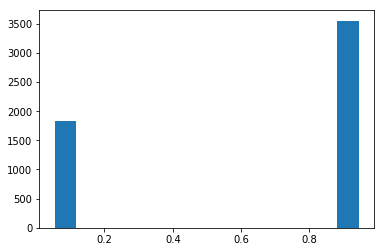

In [53]:
plt.hist(predictions, bins='auto')  # arguments are passed to np.histogram

In [54]:
testing_original = pd.read_csv('./FILE_1.csv')

In [55]:
testing_original.head()

,Business_ID,Cuisine,Rating,Num_of_Reviews
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,2.5,439.0
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,4.5,650.0
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,4.0,274.0
3,0CjK3esfpFcxIopebzjFxA,chinese,4.0,5672.0
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,4.5,1152.0


In [56]:
# add the score column to df
testing_original['score'] = predictions

In [57]:
# add the label column to df
testing_original['label'] = predictions
testing_original['label'].values[testing_original['label'] >= 0.5] = 1
testing_original['label'].values[testing_original['label'] < 0.5] = 0

In [58]:
testing_original.head()

,Business_ID,Cuisine,...,score,label
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,...,0.054237,0.0
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,...,0.945381,1.0
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,...,0.945381,1.0
3,0CjK3esfpFcxIopebzjFxA,chinese,...,0.945381,1.0
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,...,0.945381,1.0


In [59]:
# save to csv
testing_original.to_csv('testing.csv', index=False, header=True)

In [60]:
# upload to S3
boto3.Session().resource('s3').Bucket(bucket).Object('FILE_3.csv').upload_file('testing.csv')

### Exploration to the predicted values

In [62]:
testing_original.head()

,Business_ID,Cuisine,...,score,label
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,...,0.054237,0.0
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,...,0.945381,1.0
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,...,0.945381,1.0
3,0CjK3esfpFcxIopebzjFxA,chinese,...,0.945381,1.0
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,...,0.945381,1.0


In [63]:
testing_original.describe()

,Rating,Num_of_Reviews,score,label
count,5377.000000,5377.000000,5378.000000,5378.000000
mean,3.897619,240.637530,0.642810,0.660469
std,0.449017,388.286558,0.422041,0.473594
min,2.000000,1.000000,0.054237,0.000000
25%,3.500000,43.000000,0.054237,0.000000
50%,4.000000,126.000000,0.945381,1.000000
75%,4.000000,283.000000,0.945381,1.000000
max,5.000000,9134.000000,0.945381,1.000000


In [64]:
like = testing_original[testing_original['label']==1]

In [66]:
dislike = testing_original[testing_original['label']==0]

In [67]:
like.describe()

,Rating,Num_of_Reviews,score,label
count,3552.000000,3552.000000,3.552000e+03,3552.0
mean,4.165541,264.804054,9.453813e-01,1.0
std,0.256244,435.775931,5.762869e-14,0.0
min,4.000000,1.000000,9.453813e-01,1.0
25%,4.000000,46.000000,9.453813e-01,1.0
50%,4.000000,135.000000,9.453813e-01,1.0
75%,4.500000,308.000000,9.453813e-01,1.0
max,5.000000,9134.000000,9.453813e-01,1.0


In [68]:
dislike.describe()

,Rating,Num_of_Reviews,score,label
count,1825.000000,1825.000000,1.826000e+03,1826.0
mean,3.376164,193.602192,5.423684e-02,0.0
std,0.233576,267.041188,7.426650e-16,0.0
min,2.000000,1.000000,5.423684e-02,0.0
25%,3.500000,41.000000,5.423684e-02,0.0
50%,3.500000,112.000000,5.423684e-02,0.0
75%,3.500000,237.000000,5.423684e-02,0.0
max,3.500000,3150.000000,5.423684e-02,0.0
